In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
import torchnet as tnt
import random
import copy
import os
import math
import time
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import multi_dot
from scipy.sparse.linalg import cg
from scipy.sparse import csr_matrix, identity, diags
import faiss

%config InlineBackend.figure_format = 'retina'
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys
sys.path.append('/data02/Atin/vs_code_server_projects/SSL_nce/NCE/')
import unsupervised_feature_model

# Location of pretrained unsupervised model
model_state_loc = "/data02/Atin/vs_code_server_projects/SSL_nce/NCE/log/cifar_sim_clr_fresh/model_ckpt.t"

In [2]:
#load the pre trained model 
state = torch.load(model_state_loc) 
trained_model = unsupervised_feature_model.resnet_original() 
trained_model = torch.nn.DataParallel(trained_model, device_ids=range(torch.cuda.device_count()))
trained_model.load_state_dict(state['model'])
trained_model = trained_model.cuda()

In [3]:
def sem_sup_feature(conv_model:nn.Module, dl: torch.utils.data.dataloader):
    '''Extracts features from images using pretrained model
    
    Args:
        dl: dataloader
        conv_model: pretrained nn.Module object 
    
    Returns:
        Tuple[list1, list2]
        list1: 2D torch tensor of size (no. of observation, embedding dim) 
        list2: 1D array of corresponding labels 
    '''
    conv_model.eval()
    semi_supervised_feature_list = []
    label_list = []
    for b in dl:
        data, label = b
        data = data.cuda()
        with torch.no_grad():
            out = conv_model(data)
            b_size = out
            semi_supervised_feature_list.append(out)
            label_list.append(label)
    final_list = torch.cat(semi_supervised_feature_list, dim=0)
    final_label_list = torch.cat(label_list, dim=0)
    return final_list, final_label_list

In [4]:
#create data loaders
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
testset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=False,
                                           download=True, transform=transform_test)
trainset = torchvision.datasets.CIFAR10(root='/data02/Atin/CIFAR10/', train=True,
                                            download=True, transform=transform_test)

combined_dataset = torch.utils.data.ConcatDataset([trainset, testset])
combined_dataloader = torch.utils.data.DataLoader(combined_dataset, batch_size=1024, shuffle=False, num_workers=20)
feature_mat, label_arr = sem_sup_feature(trained_model, combined_dataloader)
feature_mat = feature_mat.cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


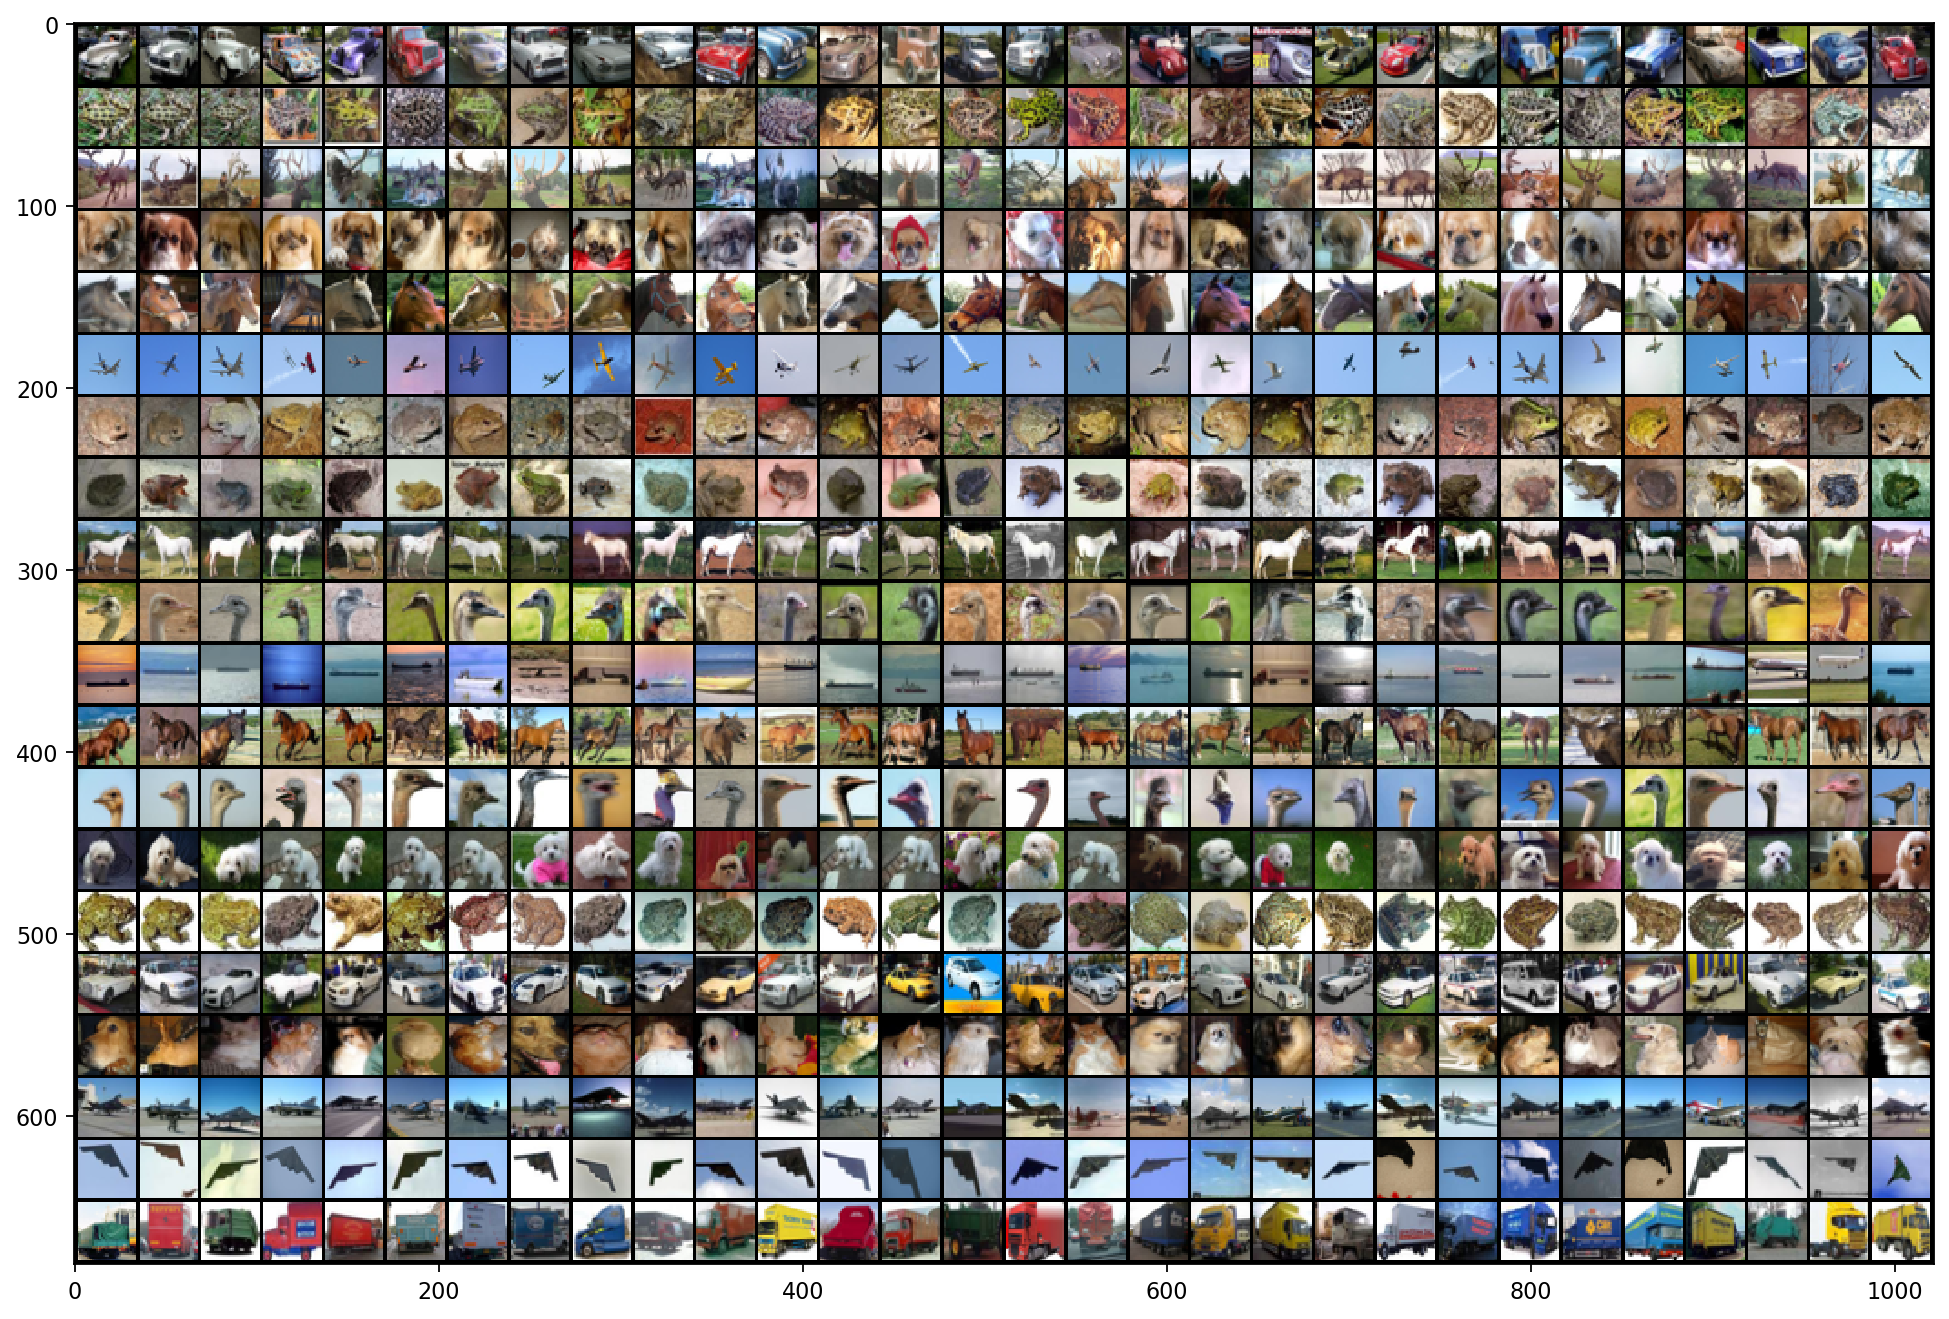

In [5]:
# Plots 30 nearest neigbor based on cosine similiarity for randomly selected rn no. of images from 60k images.
# In the leftmost cplumn we have query image

rn = 20
num_nearest_neighbor = 30

embedding_dim = 128
index = faiss.IndexFlatIP(embedding_dim)
index.add(feature_mat)
distances, indices = index.search(feature_mat, num_nearest_neighbor)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(15,20), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# Create dataset without any transformation for plotting 
cifar10_dataset_test = torchvision.datasets.CIFAR10("/data02/Atin/data/cifar10/", train=False, transform=transforms.ToTensor(), download=True)
cifar10_dataset_train = torchvision.datasets.CIFAR10("/data02/Atin/data/cifar10/", train=True, transform=transforms.ToTensor(), download=True)
cifar10_combined_dataset = torch.utils.data.ConcatDataset([cifar10_dataset_train, cifar10_dataset_test])


sample_index = random.sample(list(np.arange(len(cifar10_combined_dataset))), rn) # Sample rn indexes in (0, 60000)
sample_data = indices[sample_index].flatten()
images = torch.cat([cifar10_combined_dataset[i][0].unsqueeze(0) for i in sample_data])

grid = torchvision.utils.make_grid(images, nrow=num_nearest_neighbor)
show(grid)

In [6]:
torch.save(feature_mat, './feature_mat_from_sim_clr.t')